### Desafío - Regularización

**nombre alumno:** Julio Valdés

Profesor: Gabriel Tamayo L.

Generación: G5

Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección
correspondiente.


#### Descripción
En esta ocasión utilizaremos datos de la composición química de muestras de vino.

Nuestro propósito será tratar de predecir su calidad a partir de su composición química.

Comience su estudio realizando un breve análisis exploratorio y descriptivo:
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.
* Encuentre la cantidad de valores faltantes en cada columna.
* Grafique la distribución empírica de cada atributo.

### Ejercicio 1: Preparación del Ambiente de Trabajo
* Importe las librerías básicas
* Importe los métodos asociados a regularización
* Importe la base de datos

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (16, 6)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV

In [101]:
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Ejercicio 2: Análisis exploratorio
* Identifique el tipo de datos de cada columna.
* Identifique outliers univariados y multivariados. Los primeros los puede encontrar realizando boxplots de cada atributo, los segundos estudiando los scatterplot entre pares de atributos.

In [102]:
print('Numero de filas: {0}'.format(df.shape[0]))
print('Numero de columnas: {0}'.format(df.shape[1]))
df.info()

Numero de filas: 1599
Numero de columnas: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


#### Existen 11 variables del tipo float64 y una de tipo int64. La variable quality de tipo int64 es una variable categórica ordinal.

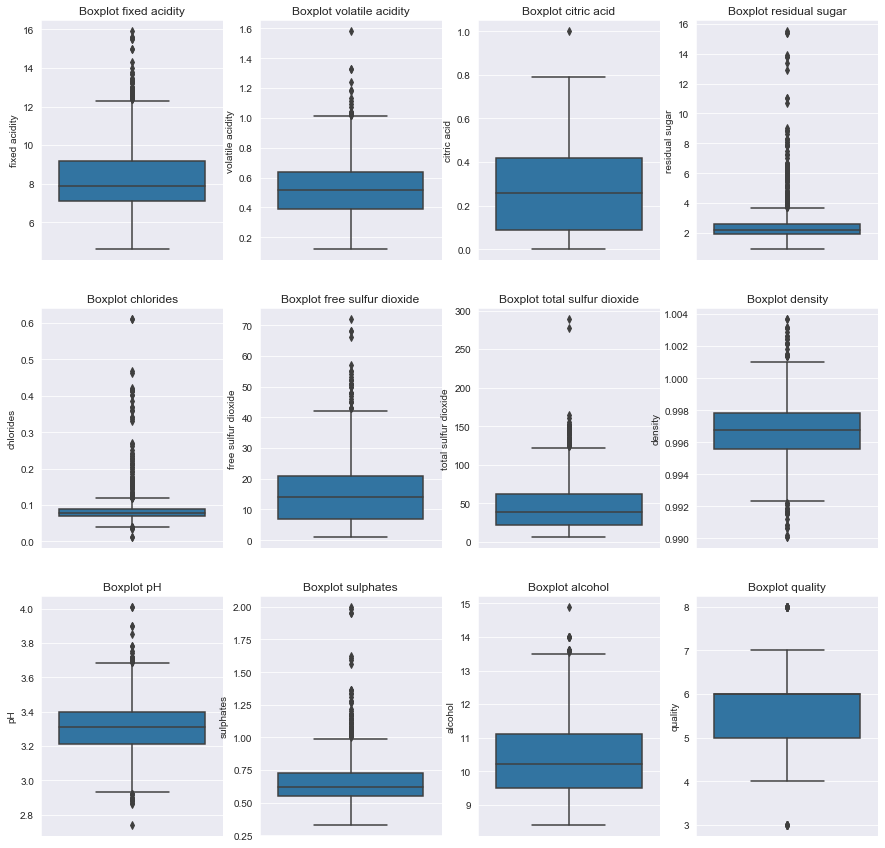

In [103]:
plt.figure(figsize=(15,15))
for key, column in enumerate(df.columns):
    plt.subplot(3, 4, key + 1)
    sns.boxplot(df[column], orient='v').set_title('Boxplot {}'.format(column), size=12)

#### Al realizar los gráficos boxplot de cada variable se observa que las variables: fixed acidity , volatile acidity, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH y sulphates presentan una alta cantidad de outliers univariados.

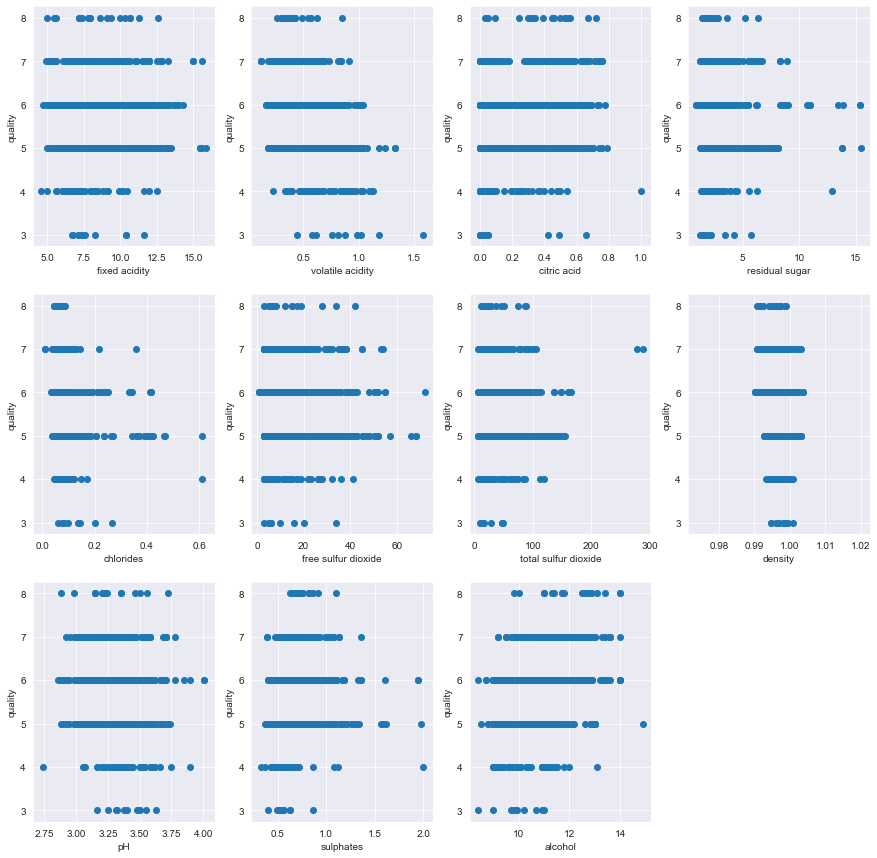

In [104]:
plt.figure(figsize=(15,15))
for key,column in enumerate(df.loc[:, 'fixed acidity':'alcohol'].columns):
    plt.subplot(3,4,key + 1)
    plt.scatter(x = df[column], y = df['quality'])
    plt.xlabel(column)
    plt.ylabel('quality')

#### Al realizar los gráficos scatterplot de la variable quality con cada una de las otras variables se observa que la mayor cantidad de registros con que se cuenta están asociados a los valores 5, 6 y 7 de quality. No se aprecia una correlación directa o inversa entre las variables y la variable quality.

### Ejercicio 3: Regularización de modelos
Genere tres modelos, correspondientes a RidgeCV , LassoCV y ElasticNetCV . Para cada uno de ellos implemente los siguientes pasos:
* Entrene los modelos con 10 validaciones cruzadas.
* Extraiga los coeficientes estimados, el mejor valor alpha, MAE (median_absolute_error) y RMSE (mean_squared_error) asociado a cada modelo.

En base a la información solicitada, responda lo siguiente:
* ¿Qué modelo presenta un mejor desempeño en base a las métricas?
* ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

Sobre los métodos RidgeCV , LassoCV y ElasticNetCV
* Para implementar la búsqueda de hiperparámetros con validación cruzada, utilizaremos la clase sklearn.linear_model.{RidgeCV, LassoCV, ElasticNetCV} .
* Por defecto, la clase necesita de una lista de valores alphas que representa el hiperparámetro de validación. Si no se define la lista, el método incorporará un array con valores por defecto.
* Por defecto la clase tendrá una opción scoring que permitirá definir la métrica con la cual se evaluará el mejor hiperparámetro. Para el caso de un problema de regresión, si no se define, la métrica será el error cuadrático promedio negativo (más alto es mejor).
* Una vez entrenado el modelo, se puede reportar el mejor alpha con modelo_entrenado.alpha_ , el valor de los coeficientes con modelo_entrenado.coef_.

In [105]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

X = df_scaled.loc[:, 'fixed acidity':'alcohol']
N = X.shape[0]
y = df_scaled['quality']
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

In [106]:
def report_regularization(model, X_test, y_test):
    print('Valor del parámetro de regularización: {0}'.format(model.alpha_))
    print('Coeficientes finales: \n{0}'.format(model.coef_))
    y_hat = model.predict(X_test)
    print('MAE: {0}'.format(median_absolute_error(y_test, y_hat)))
    print('RMSE: {0}'.format(mean_squared_error(y_test, y_hat)))

### Modelo 1: Ridge

In [107]:
ridge_cv = RidgeCV(cv = 10)
model_ridge = ridge_cv.fit(X_train, y_train)
report_regularization(ridge_cv, X_test, y_test)

Valor del parámetro de regularización: 10.0
Coeficientes finales: 
[ 0.04736789 -0.23618857 -0.03111495  0.04912042 -0.14622719  0.0590071
 -0.15950214 -0.06408254 -0.08959616  0.18813739  0.33702072]
MAE: 0.5056807608870058
RMSE: 0.6605968952852506


### Modelo 2: Lasso

In [108]:
lasso_cv = LassoCV(cv = 10)
model_lasso = lasso_cv.fit(X_train, y_train)
report_regularization(lasso_cv, X_test, y_test)

Valor del parámetro de regularización: 0.007209715861180087
Coeficientes finales: 
[ 0.         -0.22821534 -0.00242191  0.02666026 -0.14273434  0.04572997
 -0.14517619 -0.01943885 -0.09233996  0.17515783  0.35652371]
MAE: 0.4995213718352365
RMSE: 0.6580090486489001


### Modelo 3: Elastic Net

In [109]:
elasticNet_cv = ElasticNetCV(cv = 10)
model_elasticNet = elasticNet_cv.fit(X_train, y_train)
report_regularization(elasticNet_cv, X_test, y_test)

Valor del parámetro de regularización: 0.014419431722360168
Coeficientes finales: 
[ 0.         -0.22679787 -0.          0.02729485 -0.14199335  0.04408748
 -0.14366458 -0.02189939 -0.09050102  0.17444728  0.35280453]
MAE: 0.5017307347391267
RMSE: 0.6580408546638418


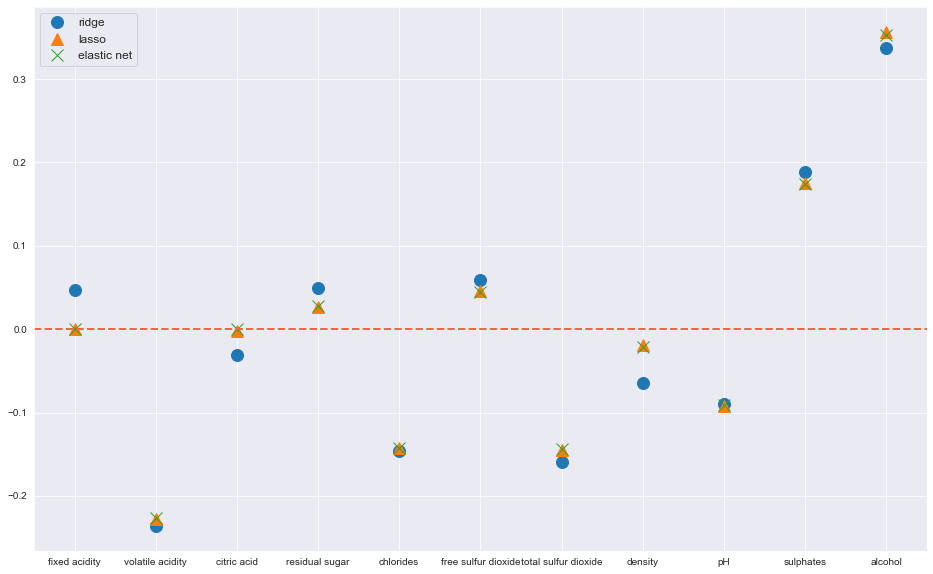

In [110]:
plt.figure(figsize=(16,10))
coeficientes = {}
coeficientes['columns'] = df.columns.drop('quality')
coeficientes['ridge'] = model_ridge.coef_
coeficientes['lasso'] = model_lasso.coef_
coeficientes['elastic net'] = model_elasticNet.coef_

plt.plot(coeficientes['columns'], coeficientes['ridge'], 'o', label = 'ridge', markersize = 12)
plt.plot(coeficientes['columns'], coeficientes['lasso'], '^', label = 'lasso', markersize = 12)
plt.plot(coeficientes['columns'], coeficientes['elastic net'], 'x', label = 'elastic net', markersize = 12)
plt.legend(loc = 2, prop = {'size': 12})

plt.axhline(0,lw = 2,color = 'tomato',linestyle = '--')

#### ¿Qué modelo presenta un mejor desempeño en base a las métricas?
* Al analizar los resultados de las métricas en los tres modelos se observan resultados similares, no siendo significativas las diferencias en el MAE y RMSE.

#### ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?
* Al observar los modelos de Lasso y Elastic Net se observa que ambos mantienen un comportamiento similar para todas las variables, siendo el modelo de Ridge el que presenta los valores distintos.
* Los atributos que mantienen un comportamiento similar en los tres modelos son: volatile acidity, chlorides, free sulfur dioxide, total sulfur dioxide, pH, sulphates y alcohol.
* Los modelos Lasso y Elastic Net señalan que los atributos fixed acidity y citric acid no son significativos para el modelo y pueden ser eliminados.